In this notebook I just create the code to generate the experiemnts of the paper, where we test the performance of the different estimators as we increase the covariate to observation ratio. In essence the code is just a looping of the code present in the notebook **Gaussian_simulated.ipynb**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
import sys
sys.path.insert(1, "./PSIS/py")
#import gaussian_model as gm
from models import Gaussian_Model as gm
import models
import psis
import pickle
sys.path.insert(1, "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/PyGauss/pygauss")
import direct_sampling as sampler

In [3]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL) 


def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [22]:
percs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2,2.5,3]
couples= []
ns = [50, 100, 150]
for n in ns:
    for perc in percs:
        couples.append((n,int(n*perc)))

##I create dictionaries now
estimates_posterior_nd = {}
estimates_mix_nd = {}
estimates_psis_nd= {}
correct_values_nd = {}
estimates_bronze_nd = {}
attempts=10
seed=82477
np.random.seed(seed)
for couple in couples:
    for attempt in range(attempts):
        print(f"I am at attempt:{attempt}, n:{couple[0]} and d:{couple[1]}", end="\r")
        n=couple[0]
        d=couple[1]

        sigma_0 = 100/(d+1)*np.identity(d+1)
        theta_0=np.zeros((d+1,1))
        var_model=1
        #model_bronze = gm.Model(theta_0, sigma_0, (n/(n-1))*var)
        x1=np.ones((n,1))
        x2=np.random.randn(n,d)
        X=np.concatenate([x1,x2],axis=1)
        theta=multivariate_normal(mean=theta_0.reshape(d+1),cov=sigma_0).rvs()
        y=multivariate_normal(mean=np.dot(X,theta),cov=var_model*np.identity(n)).rvs()
        model = gm(y, X, theta_0, sigma_0, var_model)


        full = model.log_p_full()
        leave_one_outs_p = np.array([ full-model.log_predictive_i(index) for index in range(n)])
        minimum = leave_one_outs_p.min()
        normalizer = np.sum(np.exp(leave_one_outs_p-minimum))
        weights = np.exp(leave_one_outs_p-minimum)/normalizer


        iterations=2000

        ###################################################
        ## Samples of Mixture
        res=np.random.multinomial(iterations,weights)
        X_js = [np.concatenate([X[0:index], X[index+1:]]) for index in range(n)]
        Y_js = [np.concatenate([y[0:index], y[index+1:]]) for index in range(n)]
        loos = [models.Gaussian_Model(Y_js[index], X_js[index], theta_0, sigma_0, var_model).cond_theta() for index in range(n)]
        thetas_mixture=np.zeros((X.shape[1],iterations))
        index=0
        for j in range(n):
            if res[j] > 0:
                if res[j] == 1:
                    ## I insert PyGauss sampling
                    thetas_mixture[::, index:index+1]=np.array(sampler.sampler_factorization(
                    loos[j].mean, loos[j].cov_object.covariance, mode="covariance",
                    method="Cholesky", size=res[j]))
                    index+=res[j]
                else:
                    ##again use PyGauss
                    thetas_mixture[::, index:index+res[j]]=np.array(sampler.sampler_factorization(
                    loos[j].mean, loos[j].cov_object.covariance, mode="covariance",
                    method="Cholesky", size=res[j]))
                    index+=res[j]

        posterior=model.cond_theta()
        ##use PyGauss again
        thetas_posterior=np.array(sampler.sampler_factorization(posterior.mean,
        posterior.cov_object.covariance, mode="covariance", method="Cholesky", size=iterations))
        
        #posterior_bronze = model_bronze.cond_theta(gm.State([]), y, X)
        #thetas_bronze = np.array(sampler.sampler_factorization(posterior_bronze.mean,
        #posterior_bronze.cov_matrix, mode="covariance", method="Cholesky", size=iterations,seed=seed+attempt))
        is_estimators = models.Is_estimators(model)
        correct_values = np.array([model.log_predictive_i(k) for k in range(n)])
        lppd_posterior = is_estimators.posterior(thetas_posterior)
        lppd_mixture = is_estimators.mixture(thetas_mixture)
        lppd_psis = is_estimators.PSIS(thetas_posterior)


        key = f"(n:{n}, d:{d})"
        if attempt==0:
            estimates_posterior_nd[key] = lppd_posterior.reshape((1,n))
            estimates_mix_nd[key] = lppd_mixture.reshape((1,n))
            #estimates_ew_nd[key] = np.exp(numerator_ew-denominator_ew)/(np.sqrt(2*np.pi))
            estimates_psis_nd[key]= lppd_psis.reshape((1,n))
            correct_values_nd[key] = correct_values.reshape((1,n))
            #estimates_bronze_nd[key] = lppd_bronze.reshape((1,n))
           
        else:
            estimates_posterior_nd[key] = np.concatenate([estimates_posterior_nd[key],lppd_posterior.reshape((1,n))], axis=0)
            estimates_mix_nd[key] = np.concatenate([estimates_mix_nd[key], lppd_mixture.reshape((1,n))],axis=0)
            estimates_psis_nd[key]= np.concatenate([estimates_psis_nd[key], lppd_psis.reshape((1,n))],axis=0)
            correct_values_nd[key] = np.concatenate([correct_values_nd[key], correct_values.reshape((1,n))],axis=0)
            #estimates_bronze_nd[key] = np.concatenate([estimates_bronze_nd[key], lppd_bronze.reshape((1,n))],axis=0)

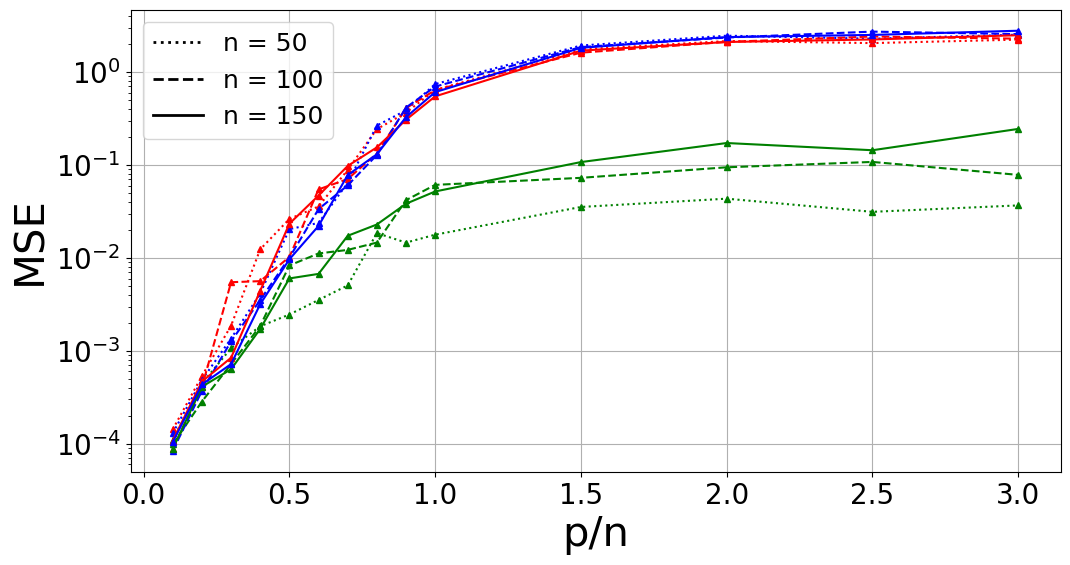

In [23]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='black', linestyle=":", lw=2, label='n = 50'),
                   Line2D([0], [0], color='black', linestyle="--", lw=2, label='n = 100'),
                   Line2D([0], [0], color='black', linestyle="-", lw=2, label='n = 150')]
                  # ,
                  #Line2D([0], [0], color='orange', linestyle="-", lw=2, label='Bronze')]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
#fig.suptitle("Average of MSEs of the different terms for mixture, posterior and psis", size=20)
linestyles = [":", "--", "-"]
for (n, ls) in zip(ns, linestyles):
    iterator2=0

    post_mse = np.zeros(len(percs))
    mix_mse = np.zeros(len(percs))
    psis_mse = np.zeros(len(percs))
    bronze_mse = np.zeros(len(percs))
    for ratio in percs:
        d = int(n*ratio)
        key = f"(n:{n}, d:{d})"
        ## I have to take out Nan is I have them
        #########################################################################################
        ##### Uncomment code if we want to calculate MSE of logs estimates ######################
        #########################################################################################
        ratio_mix=np.log(estimates_mix_nd[key]/correct_values_nd[key])
        mask=np.isinf(ratio_mix).sum(axis=1)==0
        ratio_mix=ratio_mix[mask, ::]
        
        errors_mix = estimates_mix_nd[key] - correct_values_nd[key]
        errors_psis= estimates_psis_nd[key] - correct_values_nd[key]
        errors_post=estimates_posterior_nd[key] - correct_values_nd[key]
        #errors_bronze=estimates_bronze_nd[key]-np.log(correct_values_nd[key])
        

        
        post_mse[iterator2] = np.mean(np.mean((errors_post)**2,axis=1),axis=0)
        mix_mse[iterator2] = np.mean(np.mean((errors_mix)**2,axis=1),axis=0)
        psis_mse[iterator2] = np.mean(np.mean((errors_psis)**2,axis=1),axis=0)

        iterator2+=1
        
    ##Now I plot
    ax.plot(percs, post_mse, marker = "^", ms=5, color="red", linestyle=ls, linewidth=1.5)
    ax.plot(percs, mix_mse, marker ="^", ms=5, color="green", linestyle=ls, linewidth=1.5)
    ax.plot(percs, psis_mse, marker="^", ms=5, color="blue", linestyle=ls, linewidth=1.5)
    #ax.plot(ratios, bronze_mse, marker="^", ms=5, color="orange", linestyle=ls, linewidth=1.5)
    #ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel("p/n",size=30)
    ax.set_ylabel("MSE",size=30)
    #ax.set_title(f"n:{n}")
    #iterator+=1
plt.grid()
ax.yaxis.set_tick_params(labelsize=20, rotation=0)
ax.xaxis.set_tick_params(labelsize=20, rotation=0)
plt.legend(handles=legend_elements, fontsize=18);


In [ ]:
###################### IF ONE WANTS TO SAVE THE OUTPUT ####################################

save_obj(estimates_posterior_nd, "estimates_posterior_hyperD_nd_2k_rand_10att")
save_obj(estimates_mix_nd, "estimates_mixture_hyperD_nd_2k_rand_10att")
save_obj(estimates_psis_nd, "estimates_psis_hyperD_nd_2k_rand_10att")
save_obj(correct_values_nd, "correct_values_hyperD_nd_2k_rand_10att")
#save_obj(estimates_bronze_nd, "estimates_bronze_hyperD_nd_2k_rand_1000att")